## DIANNA demo with MNIST

This notebook showcases the use of DIANNA on a subset of the MNIST
dataset. MNIST contains handwritten digits from 0 to 10. Here, we only
use 0 and 1. A binary classifier is then examined with DIANNA.

#### Install and import packages

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import onnxruntime as ort
from scipy.special import softmax

np.random.seed(42)

In [2]:
data_path = 'data/binary-mnist-data.npz'
model_path = 'models/binary-mnist-model.onnx'

#### Load binary MNIST dataset

In [3]:
data = np.load(data_path)
X = data['X_test'].astype(np.float32).reshape([-1, 1, 28, 28])
y = data['y_test']

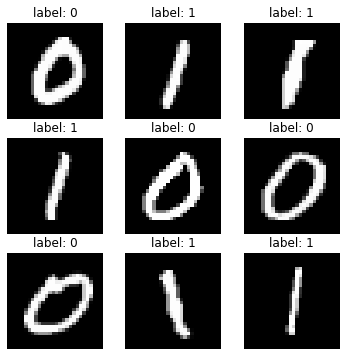

In [4]:
# Select a few random samples
selection = np.random.choice(len(X), 9, replace=False)
X_examples = X[selection]
y_examples = y[selection]

# Visualize the selected data
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(X[selection[idx]][0], cmap='gray')
    ax.set_title(f'label: {y[selection[idx]]}')
    ax.axis('off')

#### Load pre-trained model

DIANNA includes a tool to load an ONNX-format model.

In [5]:
from dianna.utils.onnx_runner import SimpleModelRunner

In [6]:
# create a class so we can get predictions out with a single call without having to reload the file every time.
class Runner:
    def __init__(self, path):
        self.model_runner = SimpleModelRunner(path)

    def __call__(self, input_data):
        output = self.model_runner(input_data)
        return softmax(output)
    
runner = Runner(model_path)

y_pred = np.argmax(runner(X_examples), axis=1)
print(y_pred)

[0 1 1 1 0 0 0 1 1]


Let's visualize the data again and add the predicted labels

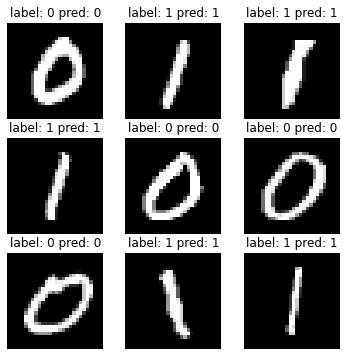

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(X[selection[idx]][0], cmap='gray')
    ax.set_title(f'label: {y[selection[idx]]} pred: {y_pred[idx]}')
    ax.axis('off')

The model is 100% correct on these 9 examples. Now we can get to the actual explainable AI part

## Explainable AI with DIANNA

In [8]:
import dianna

Select one image to use DIANNA on.
We need to tell DIANNA which axis contains the color channels of the image and for which labels we want an explanation.

In [9]:
image = X_examples[0]
axis_labels = {0: 'channels'}  # the first axis is the channel axis
labels = [0, 1]  # we want an explanation for both class 0 and class 1

The simplest way to use DIANNA is with `dianna.explain_image` or `dianna.explain_text`.  
Here we use the RISE method, which explains the input image by masking random parts of it and
then checking how the output of the model changes.

In [10]:
explanation = dianna.explain_image(model_path, image, method='RISE',
                                   n_masks=5000, p_keep=.1,
                                   axis_labels=axis_labels,
                                   labels=labels)

Explaining: 100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 88.89it/s]


For each class (two in this case), an explanation with a shape equal to the input image is generated.

In [12]:
print(explanation.shape)

(2, 28, 28)


The explanations can be considered images and can be plotted with e.g. `matplotlib`.  
DIANNA also includes visualization tools.

In [14]:
from dianna.visualization import plot_image

In [14]:
from dianna.visualization import plot_image

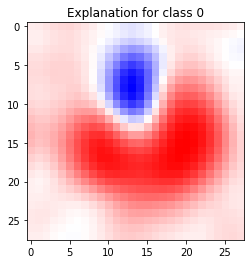

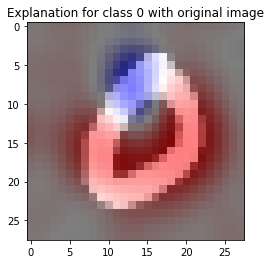

In [15]:
# Explanation for class 0
plot_image(explanation[0], heatmap_cmap='bwr', show_plot=False)
plt.title('Explanation for class 0')
plot_image(explanation[0], original_data=image[0], heatmap_cmap='bwr', data_cmap='gray', show_plot=False)
plt.title('Explanation for class 0 with original image');

Note that in these plots, red means in favour of the given class and blue means against it. We see that the left, bottom, and right side of the zero are most in favour of classifying the image as a zero, while the top part is least in favour of it.

We can also look at the heatmap for class 1.

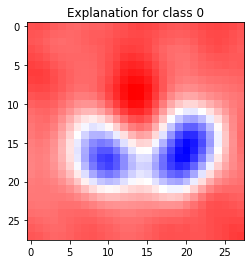

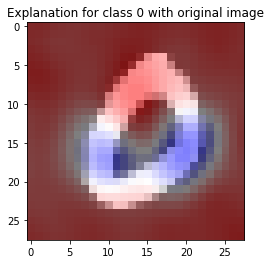

In [16]:
# Explanation for class 1
plot_image(explanation[1], heatmap_cmap='bwr', show_plot=False)
plt.title('Explanation for class 0')
plot_image(explanation[1], original_data=image[0], heatmap_cmap='bwr', data_cmap='gray', show_plot=False)
plt.title('Explanation for class 0 with original image');

This looks very similar to the explanation for class 0, but with inverted colours as expected: any pixel in favour of zero is against one, and vice-versa.